In [1]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score


We import libraries for data handling, preprocessing, modeling, and evaluation. Using scikit-learn pipelines ensures reproducibility and avoids manual preprocessing errors.

In [3]:
processed_path = "C:/Users/SHANIA/Downloads/Metro-Manila-Flood-Insights/Data/AEGISDataset_processed.csv"
df = pd.read_csv(processed_path)

In [4]:
# Target variable: observed flood height
y = df['flood_heig']

# Features: drop target
X = df.drop(columns=['flood_heig'])


 We now predict actual flood height, not the synthetic risk index. This avoids leakage and makes the model meaningful for real-world risk analysis.

In [5]:
numeric_features = ['lat', 'lon', 'elevation', 'precipitat']
categorical_features = ['elevation_bin', 'precip_bin']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

- Numeric features: Standardized so the model treats them equally (no bias from scale differences).

- Categorical features: One-hot encoded to capture bin categories. Dropping the first avoids redundancy.

- ColumnTransformer: Keeps preprocessing consistent and reproducible.

In [6]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


We combine preprocessing and modeling into one pipeline. This ensures that every time we train or test, the same transformations are applied consistently.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

We split the dataset into training and testing sets. This allows us to evaluate the model on unseen data, preventing overfitting.

In [8]:
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

We train the regression model to learn the relationship between features (elevation, precipitation, etc.) and the target (flood height).

In [9]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")


Test MSE: 3.5356
Test R²: -0.0141


We measure performance using:

- MSE (Mean Squared Error): Average squared difference between predicted and actual flood height.

- R² (Coefficient of Determination): How much variance in flood height is explained by the model.

In [10]:

comparison = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred.round(2)
})
print(comparison.head(10))


   Actual  Predicted
0       5       2.58
1       0       3.17
2       3       2.32
3       4       2.38
4       0       2.30
5       2       1.58
6       1       2.28
7       2       2.56
8       0       2.12
9       4       2.98


We provide a quick comparison of actual vs predicted values. This helps stakeholders see how well the model performs in practice.

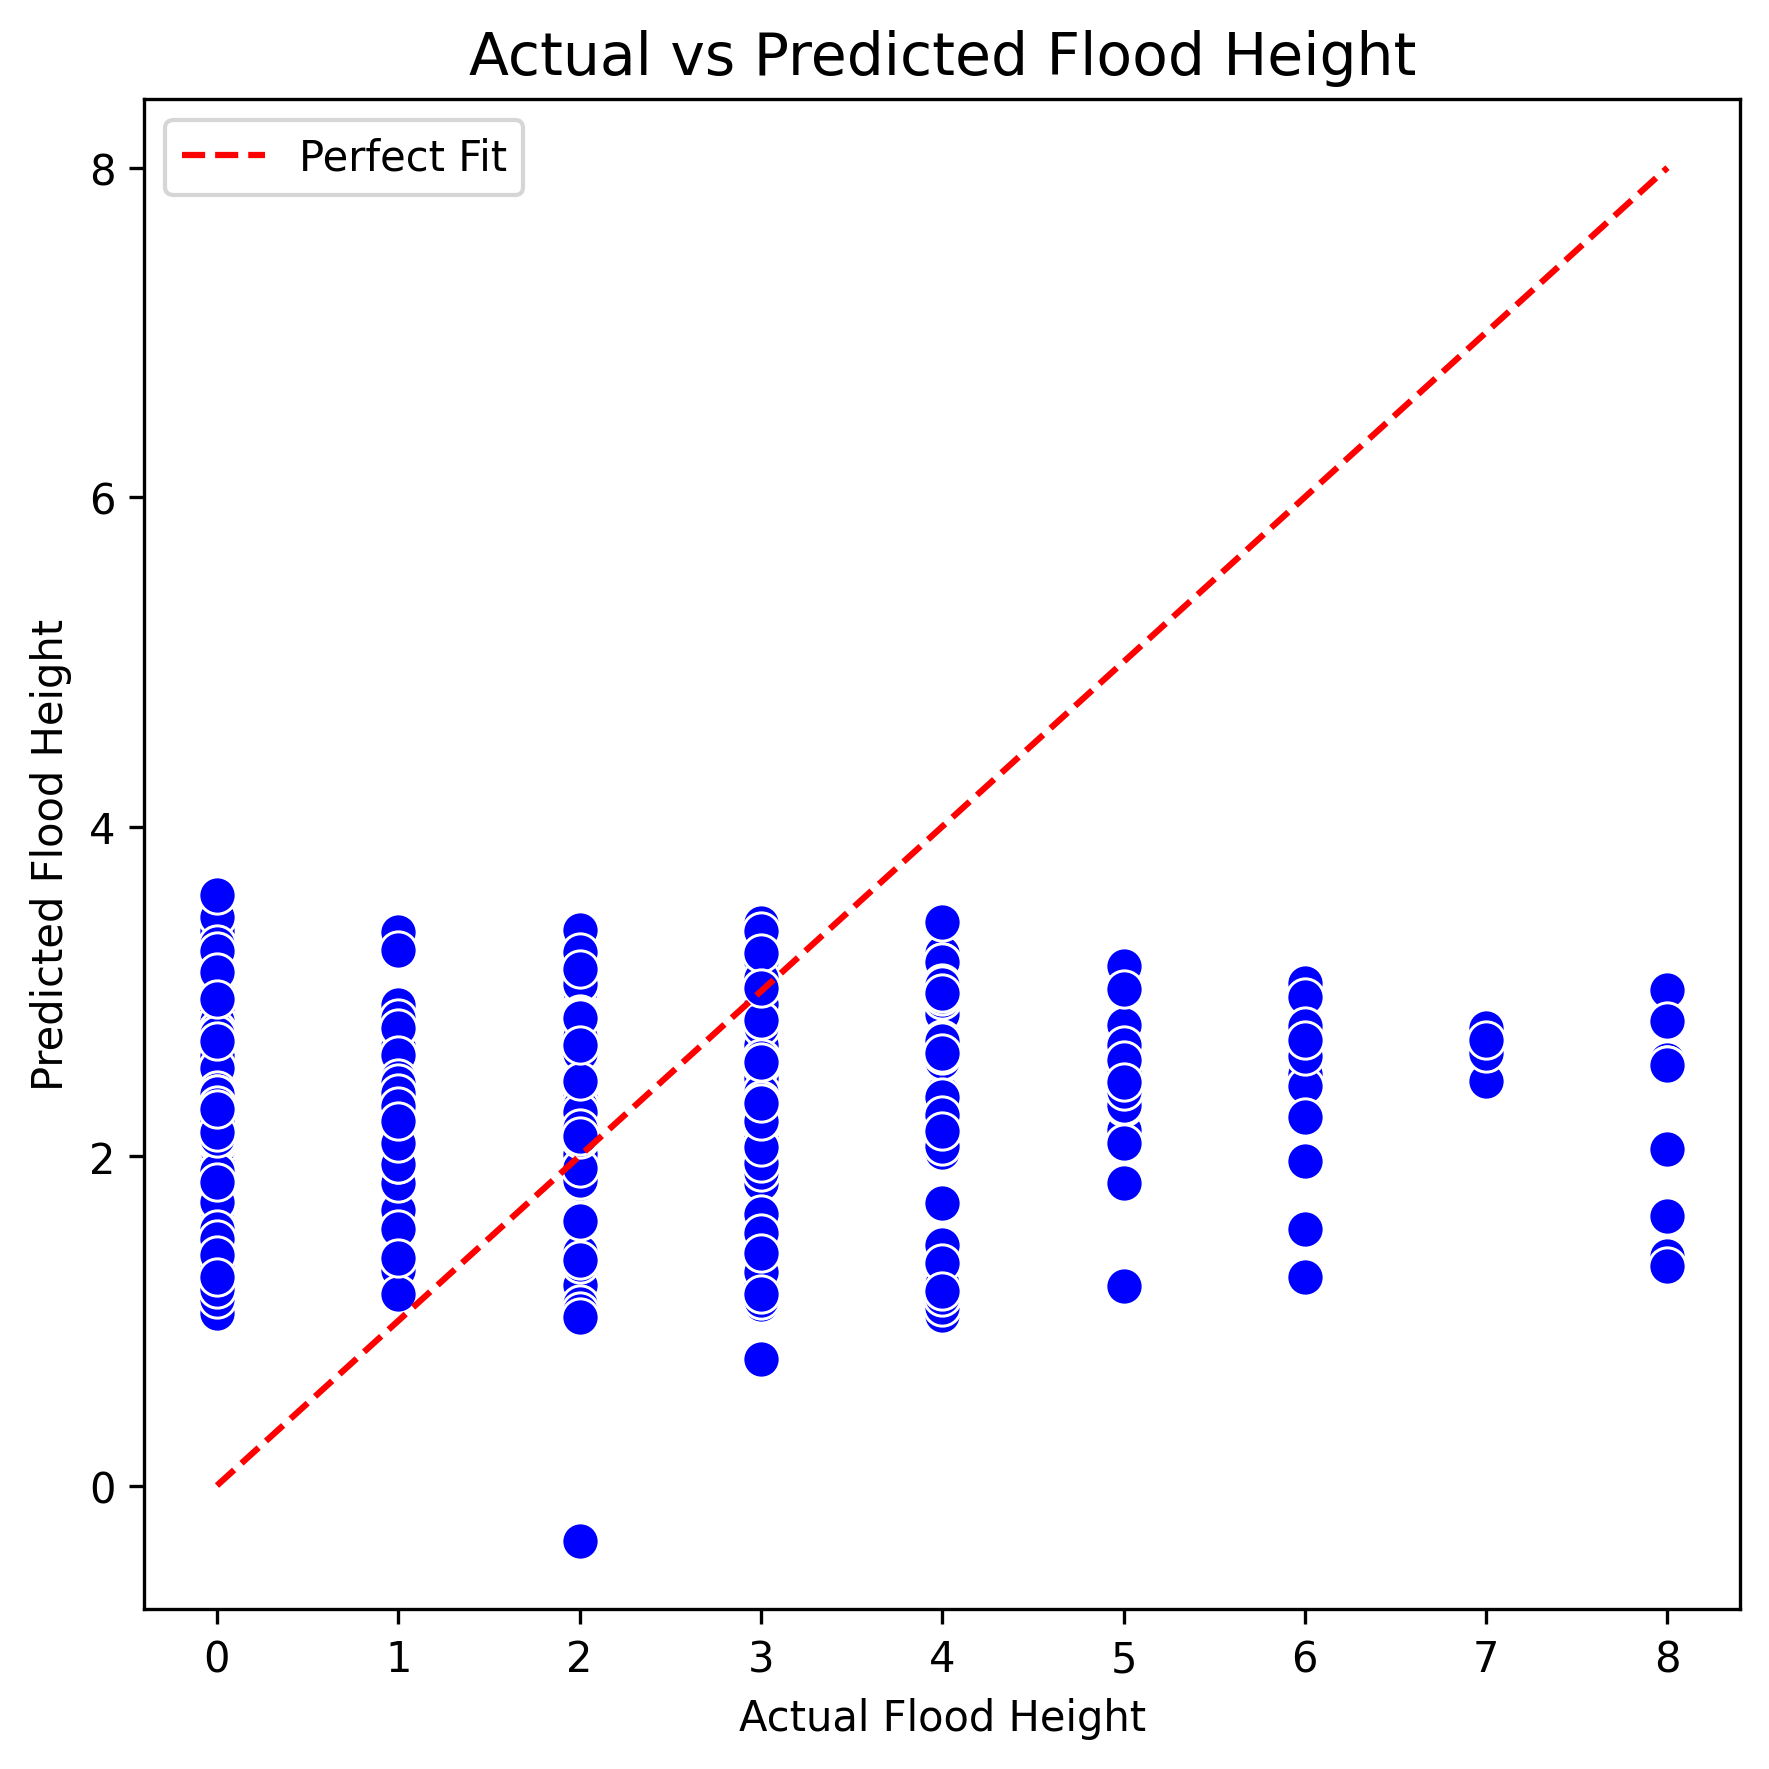

In [11]:
plt.figure(figsize=(6,6), dpi=300)
sns.scatterplot(x=y_test, y=y_pred, color='blue', s=80)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit')
plt.title("Actual vs Predicted Flood Height", fontsize=14)
plt.xlabel("Actual Flood Height")
plt.ylabel("Predicted Flood Height")
plt.legend()
plt.tight_layout()
plt.show()

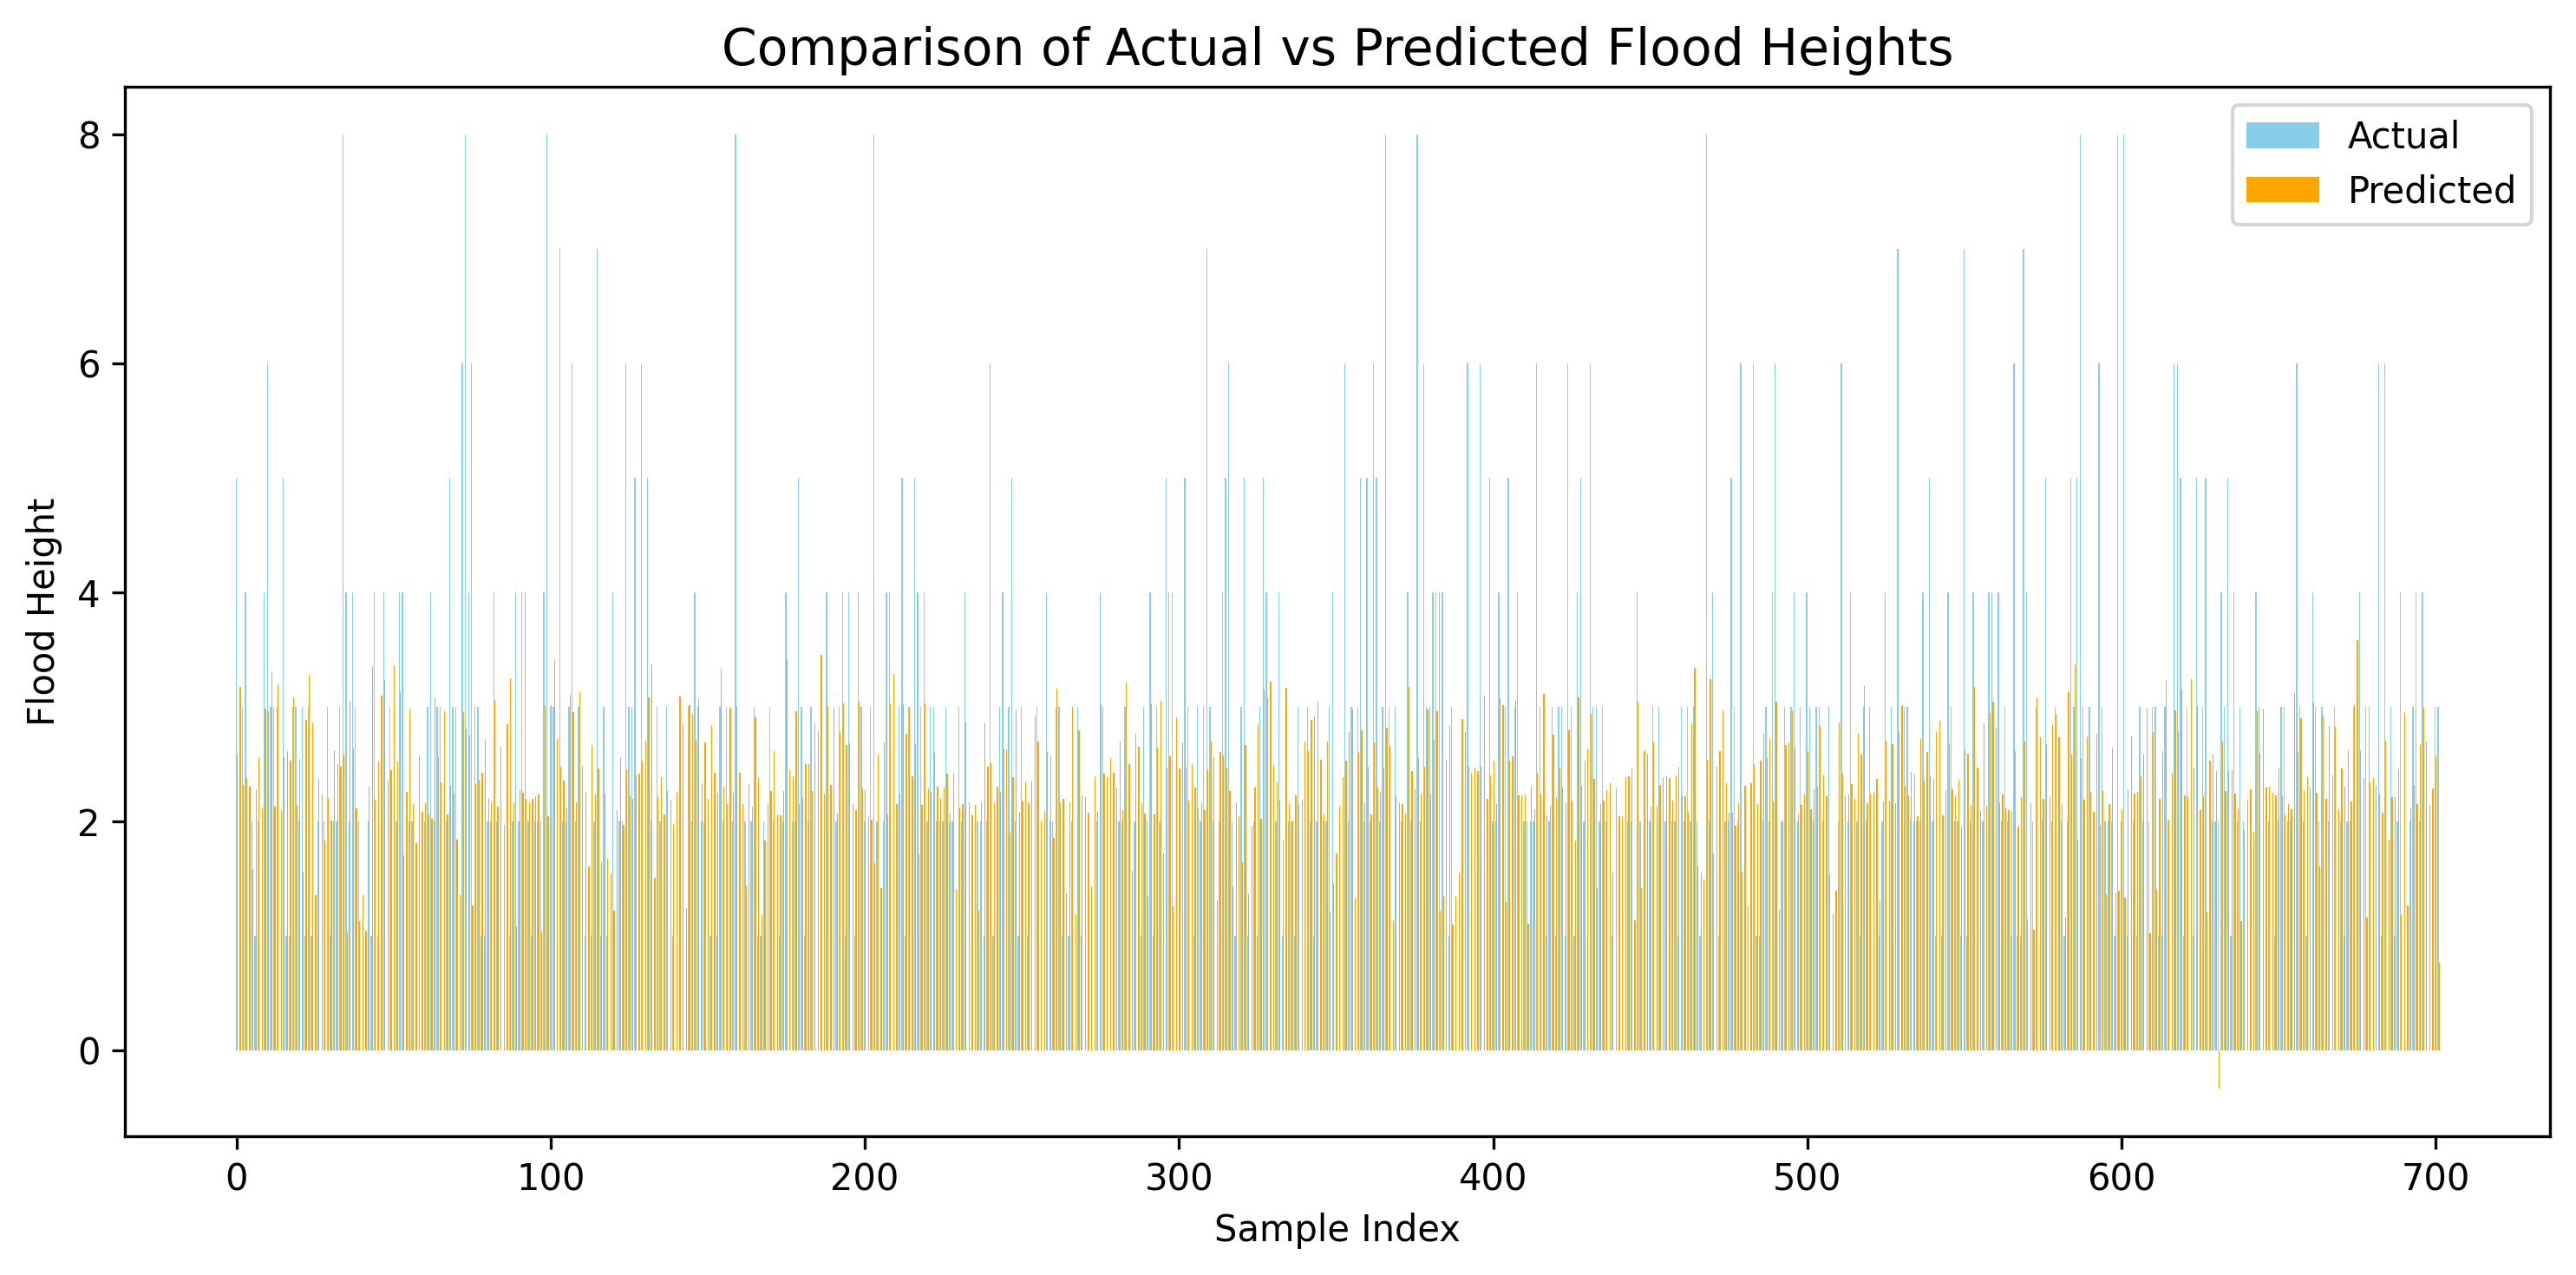

In [12]:
plt.figure(figsize=(10,5), dpi=300)
indices = np.arange(len(y_test))
width = 0.35
plt.bar(indices - width/2, y_test, width, label='Actual', color='skyblue')
plt.bar(indices + width/2, y_pred, width, label='Predicted', color='orange')
plt.title("Comparison of Actual vs Predicted Flood Heights", fontsize=14)
plt.xlabel("Sample Index")
plt.ylabel("Flood Height")
plt.legend()
plt.tight_layout()
plt.show()

### Model Performance
- Linear Regression gave us **MSE ≈ 3.53** and **R² ≈ -0.01**.  
- This means the model explains almost none of the variance in flood height and performs worse than simply predicting the average.

### Interpretation
- Predictions are biased toward the mean:  
  - High flood heights are **underpredicted** (e.g., actual 5 → predicted ~2.6).  
  - Zero floods are **overpredicted** (e.g., actual 0 → predicted ~3).  
- This happens because Linear Regression assumes straight-line relationships, while flood risk is **nonlinear and threshold-based**.  
- Raw latitude/longitude values don’t add much explanatory power in a linear model. They need to be transformed into spatial features (clusters, distances, neighborhood averages).

### Decision Point
- **Linear Regression stays as our baseline.** It shows the limits of simple models.  
- Next, we need to try **nonlinear models** (Random Forest, Gradient Boosting) that can capture thresholds and interactions.  
- We should also consider **classification framing** (None, Low, Moderate, High severity) to make outputs more actionable for BI dashboards.  
- Later, we’ll add **geospatial features** to reflect neighborhood and terrain effects.

### Next Steps
1. Run Random Forest as the next benchmark.  
2. Compare performance with Gradient Boosting.  
3. Reframe target into severity categories for BI clarity.  
4. Engineer spatial features to align with the GIS-driven goal.
